In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import xgboost as xgb
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# EDA

In [6]:
org_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
sample = pd.read_csv("data/sample_submission.csv")
features_df = pd.read_csv("cleaned_features.csv")

### Check Outliers

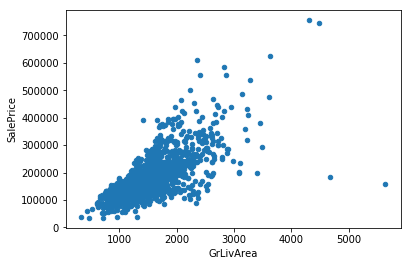

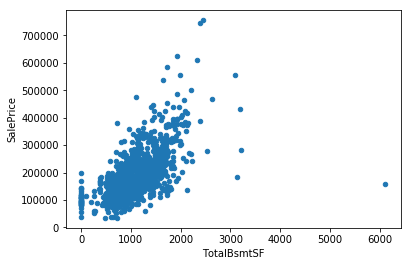

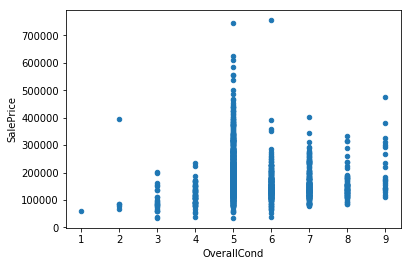

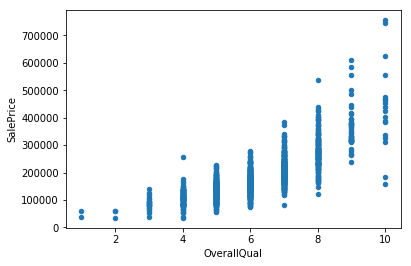

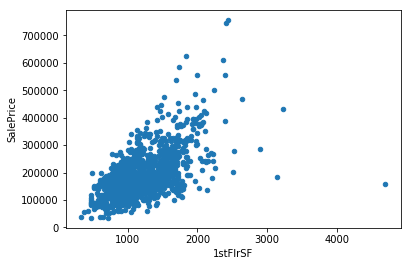

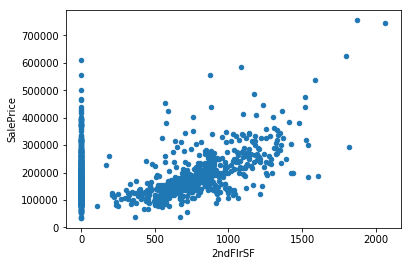

In [39]:
for col in ["GrLivArea", "TotalBsmtSF", "OverallCond", "OverallQual", "1stFlrSF", "2ndFlrSF"]:
    org_df.plot.scatter(x = col, y = "SalePrice")

### Remove Outliers

In [8]:
org_df = org_df.loc[org_df["GrLivArea"] < 4500]
org_df = org_df.loc[org_df["TotalBsmtSF"] < 6000]
org_df = org_df.loc[org_df["1stFlrSF"] < 4000]

In [9]:
org_df.shape

(1458, 81)

### Check Target Distribution

In [21]:
target = org_df["SalePrice"]
log_target = np.log(target)

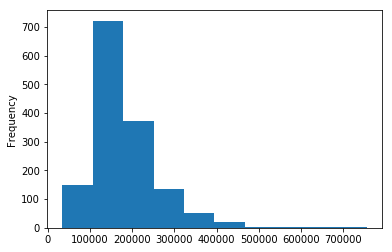

In [565]:
target.plot.hist()

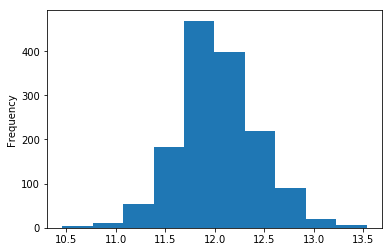

In [523]:
log_target.plot.hist()

In [266]:
print(org_df.shape)
print(test_df.shape)

(1458, 81)
(1459, 80)


# Feature Engineering

In [11]:
features_df = pd.concat([org_df, test_df], axis = 0).drop(["Id","SalePrice", "Utilities"], axis = 1)
features_df.shape

(2917, 78)

In [201]:
features_df["SaleType"].value_counts()

WD       2525
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [12]:
def get_nadf (df):
    cols_df = pd.DataFrame(df.isna().sum()[df.isna().sum() != 0])
    cols_df.columns = ["NAs"]
    cols_df["NA_Percentail"] = (cols_df["NAs"]/df.shape[0])*100
    return cols_df
get_nadf(features_df)

,NAs,NA_Percentail
Alley,2719,93.212204
BsmtCond,82,2.811107
BsmtExposure,82,2.811107
BsmtFinSF1,1,0.034282
BsmtFinSF2,1,0.034282
BsmtFinType1,79,2.708262
BsmtFinType2,80,2.742544
BsmtFullBath,2,0.068564
BsmtHalfBath,2,0.068564
BsmtQual,81,2.776826


In [166]:
features_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,None,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,None,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,None,0,2,CollgCr,61,5,7,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,8,856.0,0,2003,2003,2008
1,1262,0,0,None,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,None,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,None,0,5,Veenker,0,8,6,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,6,1262.0,298,1976,1976,2007
2,920,866,0,None,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,None,0,9,CollgCr,42,5,7,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,6,920.0,0,2001,2002,2008
3,961,756,0,None,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,None,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,None,0,2,Crawfor,35,5,7,Y,0,None,CompShg,Gable,Abnorml,WD,0,Pave,7,756.0,0,1915,1970,2006
4,1145,1053,0,None,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,None,0,12,NoRidge,84,5,8,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,9,1145.0,192,2000,2000,2008


In [13]:
# Fill NA with None and 0
for col in ["BsmtCond", "BsmtQual", "BsmtFinType1", "BsmtExposure", "BsmtFinType2", "GarageType", "GarageFinish",
           "GarageQual", "GarageCond", "Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature", "MasVnrType",
           "KitchenQual", "Exterior1st", "Exterior2nd"]:
    features_df[col] = features_df[col].fillna("None")
    
for col in ["MasVnrArea", "GarageYrBlt", "TotalBsmtSF", "BsmtFinSF1", "BsmtFinSF2", "BsmtFullBath", "BsmtHalfBath",
           "BsmtUnfSF", "GarageArea", "GarageCars"]:
    features_df[col] = features_df[col].fillna(0)

In [14]:
# Fill NA with Median
features_df["LotFrontage"] = features_df["LotFrontage"].fillna(np.median(features_df.loc[features_df["LotFrontage"].notnull(), "LotFrontage"]))

In [15]:
# Fill NA with Mode
features_df["Electrical"] = features_df["Electrical"].fillna("SBrkr")
features_df["MSZoning"] = features_df["MSZoning"].fillna("RL")
features_df["Functional"] = features_df["Functional"].fillna("Typ")
features_df["SaleType"] = features_df["SaleType"].fillna("WD")

In [16]:
# Change to str because of not ordinal
features_df[["MSSubClass", "OverallQual", "OverallCond"]] = features_df[["MSSubClass", "OverallQual", "OverallCond"]].astype("str")

In [17]:
# Generate 8 new features
features_df["TotalSF"] = features_df["GrLivArea"] + features_df["TotalBsmtSF"]
features_df["YrBtwRemod"] = features_df["YrSold"] - features_df["YearRemodAdd"]
features_df["HouseAge"] = features_df["YrSold"] - features_df["YearBuilt"]
features_df["IfBsmtUf"] = [1 if e != 0 else 0 for e in features_df["BsmtUnfSF"]]
features_df["IfLowQC"] = [1 if e != 0 else 0 for e in features_df["LowQualFinSF"]]
features_df["If3SsnPorch"] = [1 if e != 0 else 0 for e in features_df["3SsnPorch"]]
features_df["IfEnclosedPorch"] = [1 if e != 0 else 0 for e in features_df["EnclosedPorch"]]
features_df["Pool"] = [1 if e != 0 else 0 for e in features_df["PoolArea"]]

# Modeling

In [18]:
dummied_features = pd.get_dummies(features_df, drop_first = True)
dummied_features.shape

(2917, 297)

In [19]:
train = dummied_features[:1458]
test = dummied_features[1458:]

## Lasso

In [22]:
lasso = Lasso()
alphas = np.linspace(0, 0.005, 20)
grid_param = [{"alpha": alphas}]
lasso.set_params(normalize = True)
n_folds = 10

clf = GridSearchCV(lasso, grid_param, cv = n_folds, refit = False)
clf.fit(train, log_target)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

In [27]:
print(clf.best_params_)
print(clf.best_score_)

{'alpha': 0.0002631578947368421}
0.9019459542786269


In [28]:
scores

array([0.90152217, 0.90194595, 0.87458583, 0.84882184, 0.82669755,
       0.80915855, 0.7914366 , 0.7747509 , 0.75709373, 0.73890606,
       0.72068405, 0.7005188 , 0.67840342, 0.65433324, 0.62831387,
       0.60034778, 0.57076007, 0.54084214, 0.50971505, 0.47942306])

In [58]:
clf.best_params_

{'alpha': 0.00010526315789473685}

In [22]:
# Using Lasso to check new feature importance
lasso = Lasso()
lasso.set_params(alpha = 0.000263, normalize = False)
lasso.fit(train, log_target)
coefs_df = pd.concat([pd.DataFrame(train.columns), pd.DataFrame(lasso.coef_)], axis = 1)
coefs_df.columns = ["Col", "Coef"]
coefs_df.sort_values(by="Coef", ascending = False)
coefs_df.loc[coefs_df["Col"] == "IfLowQC"]

,Col,Coef
37,IfLowQC,-0.007639


In [23]:
lasso = Lasso(alpha = 0.000263, normalize = False)
lasso.fit(train, log_target)
lasso_pre = lasso.predict(test)

In [24]:
np.exp(lasso_pre)

array([117552.67572177, 150618.65882093, 186518.39378784, ...,
       175178.87011055, 115439.89251881, 218609.48063697])

In [25]:
sample["SalePrice"] = np.exp(lasso_pre)
sample.to_csv("lasso4.csv", index = False)

In [24]:
pre_log_y = lasso.predict(train)

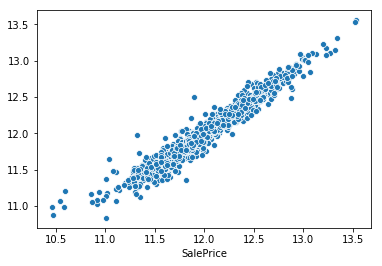

In [25]:
sns.scatterplot(x = log_target, y = pre_log_y)

In [22]:
# RMSE
(np.mean((pre_log_y - log_target)**2))**.5

0.09244662841917678

### Residual plot to check assumptions

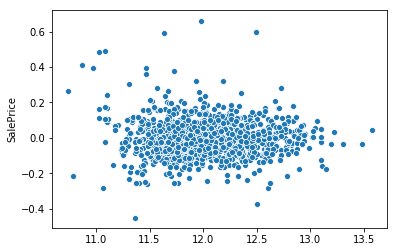

In [79]:
log_residuals = pre_log_y - log_target
sns.scatterplot(x = pre_log_y, y = log_residuals)

## Ridge

In [17]:
ridge = Ridge()
alphas = np.linspace(0.2, 0.3, 20)
grid_param = [{"alpha": alphas}]
ridge.set_params(normalize = True)
n_folds = 10

clf = GridSearchCV(ridge, grid_param, cv = n_folds, refit = False)
clf.fit(train, log_target)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

In [18]:
scores

array([0.9106905 , 0.91071265, 0.91073169, 0.91074773, 0.91076089,
       0.91077128, 0.910779  , 0.91078414, 0.91078679, 0.91078704,
       0.91078497, 0.91078067, 0.9107742 , 0.91076564, 0.91075505,
       0.91074251, 0.91072807, 0.91071179, 0.91069372, 0.91067393])

In [19]:
print(clf.best_params_)
print(clf.best_score_)

{'alpha': 0.24736842105263157}
0.9107870385742644


In [36]:
ridge = Ridge(alpha = 0.247368, normalize = False)
ridge.fit(train, log_target)
ridge_pre = ridge.predict(test)

## ElasticNet

In [26]:
ela = ElasticNet(normalize = True)
alphas = np.linspace(0, 0.001, 20)
l1r = np.linspace(0.3,0.6,10)
grid_param = [{"alpha": alphas, "l1_ratio": l1r}]
n_folds = 10
clf = GridSearchCV(ela, grid_param, cv = n_folds, refit = False)
clf.fit(train, log_target)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

In [27]:
print(clf.best_params_)
print(clf.best_score_)

{'alpha': 0.00010526315789473685, 'l1_ratio': 0.5333333333333333}
0.9145055072269261


In [159]:
ela = ElasticNet(alpha = 0.000105, l1_ratio = 0.5333, normalize=False)
ela.fit(train, log_target)
ela_pre = ela.predict(test)

## Tree Models

In [10]:
le = preprocessing.LabelEncoder()
cat_cols = features_df.dtypes[(features_df.dtypes != "int64") & (features_df.dtypes != "float64")].index
tr_features = features_df.copy()

In [11]:
for col in cat_cols:
    le.fit(tr_features[col])
    tr_features[col] = le.transform(tr_features[col])

In [12]:
tr_train = tr_features[:1458]
tr_test = tr_features[1458:]

In [46]:
print(clf.best_params_)

{'max_depth': 150, 'n_estimators': 1000}


## Gradient Boosting

In [213]:
gbm = GradientBoostingRegressor(loss = "huber", max_features = "sqrt", learning_rate = 0.03)
depth = [2,3,5]
n_est = [1000,2000,3000]
grid_param = [{"max_depth": depth, "n_estimators": n_est}]
n_folds = 5

clf = GridSearchCV(gbm, grid_param, cv = n_folds, refit = False)
clf.fit(train, log_target)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

In [214]:
scores

array([0.9091881 , 0.90827231, 0.91193387, 0.90957173, 0.91181317,
       0.9085139 , 0.90761694, 0.90689993, 0.90641198])

In [215]:
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 2, 'n_estimators': 3000}
0.911933869081196


In [216]:
gbm = GradientBoostingRegressor(max_features = "sqrt", learning_rate = 0.03, max_depth = 2, n_estimators = 3000, loss = "huber")
gbm.fit(tr_train, log_target)
gbm_pre = gbm.predict(test)

## Extreme Boosting

In [ ]:
egb = xgb.XGBRegressor(loss = "huber", silent = 1, eta = 0.01)
depth = [2,3,6]
n_est = [300,600,900]
csby = [0.4, 0.5, 0.6]
grid_param = [{"max_depth": depth, "n_estimators": n_est, "colsample_bytree": csby}]
n_folds = 5

clf = GridSearchCV(egb, grid_param, cv = n_folds, refit = False)
clf.fit(tr_train, log_target)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

In [14]:
print(clf.best_params_)
print(clf.best_score_)

{'colsample_bytree': 0.4, 'max_depth': 2, 'n_estimators': 900}
0.9122473907197862


In [30]:
print(clf.best_params_)
print(clf.best_score_)

{'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
0.914444428999778


In [19]:
scores

array([0.90917716, 0.91063892, 0.9105416 , 0.91108078, 0.91216827,
       0.91163756, 0.90467494, 0.90474719, 0.90474844, 0.91027003,
       0.91194065, 0.91180612, 0.91196933, 0.91231749, 0.91158804,
       0.90996179, 0.91008565, 0.91008657, 0.90742095, 0.90947112,
       0.90975055, 0.91073942, 0.9116716 , 0.91205319, 0.90459512,
       0.90428393, 0.90428565])

In [14]:
egb = xgb.XGBRegressor(loss = "huber", eta = 0.01, max_depth = 3, n_estimators = 600, colsample_bytree = 0.5)
egb.fit(tr_train, log_target)
egb_pre = egb.predict(tr_test)

In [21]:
sample["SalePrice"] = (np.exp(gbm_pre)+np.exp(egb_pre)+stackedlinear["SalePrice"])/3

In [14]:
sample["SalePrice"] = np.exp(egb_pre)

In [23]:
sample.to_csv("StackedAll.csv", index = False)

In [13]:
slog_target = log_target.reset_index()["SalePrice"]
strain = train.reset_index().drop("index", axis = 1)
str_train = tr_train.reset_index().drop("index", axis = 1)

# Stacking

In [15]:
x_lintr, x_lintst, y_tr = strain, test, slog_target
x_treetr, x_treetst = str_train, tr_test

In [16]:
kf = KFold(n_splits=5, random_state = 0, shuffle = False)

In [25]:
lasso_train = []
lasso_test = []
for tr, ts in kf.split(x_lintr):
    train_idx = list(x_lintr.index[tr])
    test_idx = list(x_lintr.index[ts])
    lasso = Lasso(alpha = 0.000105, normalize = False)
    lasso.fit(x_lintr.loc[train_idx],y_tr.loc[train_idx])
    lasso_train.extend(lasso.predict(x_lintr.loc[test_idx]))
    lasso_test.append(lasso.predict(x_lintst))
lasso_test = [e/5 for e in sum(lasso_test)]

In [26]:
ridge_train = []
ridge_test = []
for tr, ts in kf.split(x_lintr):
    train_idx = list(x_lintr.index[tr])
    test_idx = list(x_lintr.index[ts])
    ridge = Ridge(alpha = 0.000105, normalize = False)
    ridge.fit(x_lintr.loc[train_idx],y_tr.loc[train_idx])
    ridge_train.extend(ridge.predict(x_lintr.loc[test_idx]))
    ridge_test.append(ridge.predict(x_lintst))
ridge_test = [e/5 for e in sum(ridge_test)]

In [27]:
ela_train = []
ela_test = []
for tr, ts in kf.split(x_lintr):
    train_idx = list(x_lintr.index[tr])
    test_idx = list(x_lintr.index[ts])
    ela = ElasticNet(alpha = 0.000105, l1_ratio = 0.5333, normalize=False)
    ela.fit(x_lintr.loc[train_idx],y_tr.loc[train_idx])
    ela_train.extend(ela.predict(x_lintr.loc[test_idx]))
    ela_test.append(ela.predict(x_lintst))
ela_test = [e/5 for e in sum(ela_test)]

In [28]:
gbm_train = []
gbm_test = []
for tr, ts in kf.split(x_treetr):
    train_idx = list(x_treetr.index[tr])
    test_idx = list(x_treetr.index[ts])
    gbm = GradientBoostingRegressor(max_features = "sqrt", learning_rate = 0.03, max_depth = 2, n_estimators = 3000, loss = "huber")
    gbm.fit(x_treetr.loc[train_idx],y_tr.loc[train_idx])
    gbm_train.extend(gbm.predict(x_treetr.loc[test_idx]))
    gbm_test.append(gbm.predict(x_treetst))
gbm_test = [e/5 for e in sum(gbm_test)]

In [30]:
stacked_train = pd.DataFrame({"lasso":lasso_train,"ridge": ridge_train,"ela": ela_train,"gbm": gbm_train})
stacked_test = pd.DataFrame({"lasso":lasso_test,"ridge": ridge_test,"ela": ela_test,"gbm": gbm_test})
stacked_train.to_csv("stacked_train.csv", index = False)
stacked_test.to_csv("stacked_test.csv", index = False)

In [27]:
stacked_train["lasso"] = np.log(lasso3["SalePrice"])

In [29]:
stacked_train.to_csv("stacked_train.csv", index = False)
stacked_test.to_csv("stacked_test.csv", index = False)

In [17]:
xgb_train = []
xgb_test = []
for tr, ts in kf.split(x_treetr):
    train_idx = list(x_treetr.index[tr])
    test_idx = list(x_treetr.index[ts])
    egb = xgb.XGBRegressor(loss = "huber", eta = 0.01, max_depth = 3, n_estimators = 600, colsample_bytree = 0.5)
    egb.fit(x_treetr.loc[train_idx],y_tr.loc[train_idx])
    xgb_train.extend(egb.predict(x_treetr.loc[test_idx]))
    xgb_test.append(egb.predict(x_treetst))
xgb_test = [e/5 for e in sum(xgb_test)]

In [3]:
stacked_train = pd.read_csv("stacked_train.csv")
stacked_test = pd.read_csv("stacked_test.csv")

In [19]:
stacked_train["xgb"] = xgb_train
stacked_test["xgb"] = xgb_test

In [33]:
lasso = Lasso(alpha = 0, normalize = False)
lasso.fit(stacked_train, slog_target)
stacked_pre = lasso.predict(stacked_test)

In [35]:
sample["SalePrice"] = np.exp(stacked_pre)
sample.to_csv("StackedRegressor.csv", index = False)

In [36]:
lasso = Lasso(alpha = 0.000105, normalize = False)
ridge = Ridge(alpha = 0.000105, normalize = False)
ela = ElasticNet(alpha = 0.000105, l1_ratio = 0.5333, normalize=False)

stregr = StackingRegressor(regressors=[lasso,ridge,ela], meta_regressor=lasso)

In [37]:
stregr.fit(train,log_target)
str_pre = stregr.predict(test)

In [39]:
sample["SalePrice"] = np.exp(str_pre)
sample.to_csv("stackedlinear.csv", index = False)

In [192]:
sample["SalePrice"] = gbmfinal["SalePrice"]*0.25 + lasso3*0.5 + xgbfinal["SalePrice"]*0.25
sample.to_csv("la6.csv", index = False)